<a href="https://colab.research.google.com/github/lookingglasslab/VisualFeatureSearch/blob/widen-support/notebooks/Interactive_Visual_Feature_Search_Basic_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Visual Feature Search
## Basic Demo

This colab notebook implements our interactive visual feature search, which allows a user to highlight a free-form region in an image and do a "reverse image search" in CNN intermediate features for similar regions in a dataset.

In this notebook, we use cached ResNet-50 activations for CoCo's validation set.

For fastest results, enable colab's GPU runtime. With a GPU, the search should take < 5 seconds. For source code, see our [Github repo](https://github.com/lookingglasslab/VisualFeatureSearch).

We recommend you execute cell blocks sequentially one at a time, as some cells require user input before the rest of the notebook proceeds.

## Environment Initialization & Downloads

In [ ]:
!wget https://azcopyvnext.azureedge.net/release20220511/azcopy_linux_amd64_10.15.0.tar.gz
!tar -xvf azcopy_linux_amd64_10.15.0.tar.gz

!pip install zarr

!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip

# the cached feature data
!./azcopy_linux_amd64_10.15.0/azcopy copy https://vissearch.blob.core.windows.net/data/ResNet_COCO_08172023_f16.tar.gz ResNet_COCO_08172023_f16.tar.gz
!tar -xzf ResNet_COCO_08172023_f16.tar.gz

In [ ]:
# TODO: change to regular pip upon release
!pip install -i https://test.pypi.org/simple/ --no-deps visualfeaturesearch==0.0.11

## Setup

In [ ]:
import sys
import numpy as np
import requests
import json
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
import zarr

import visualfeaturesearch as vfs
from visualfeaturesearch.searchtool import CachedSearchTool

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  raise Exception('No GPU available')

To set up VFS, we:

1.   Load a ResNet50 model with ImageNet pretraining
2.   Select the specific layer that we want to visualize features from (in this case, one of the final layers from the conv5 block)
3.   Load precomputed feature data for the dataset we search across (i.e. the COCO validation set)



In [ ]:
model = torchvision.models.resnet50(pretrained=True)
model = model.cuda().eval()

model_conv5 = vfs.util.FeatureHook(model, model.layer4[2].conv2)

cache_store = zarr.DirectoryStore('ResNet_COCO_08172023_f16')
cache_root = zarr.group(store=cache_store, overwrite=False)
cache_conv5_data = torch.tensor(cache_root['conv5'][:]).to(device)

cached_search_tool = CachedSearchTool(model_conv5, cache_conv5_data, device, batch_size=5000)

For this demo, we also define a function for downloading COCO images:

In [ ]:
def get_coco_image(name):
  url = 'http://images.cocodataset.org/val2014/' + name
  img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
  return vfs.data.vis_transform(img)

with open('annotations/instances_val2014.json') as f:
  ds_info = json.load(f)

img_names = []
for img_data in ds_info['images']:
  img_names.append(img_data['file_name'])
img_names.sort()

## Search Tool

Below is our GUI for selecting an image and highlighting a region within it to search for. We first download 10 images from the ImageNet test set, which we then feed into the widget so we can use them in our search queries.

In [ ]:
# download ten query images to use (sourced from the ImageNet test set)
IMG_DOWNLOAD_URL = "https://vissearch.blob.core.windows.net/query-imgs/ILSVRC2012_test_00000"
query_img_ids = ["004", "530", "495", "211", "652", "021", "686", "016", "713", "198"]

def load_img(idx: str):
  url = IMG_DOWNLOAD_URL + idx + ".JPEG"
  img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
  return img

query_imgs = [load_img(id) for id in query_img_ids]
vis_query_imgs = [vfs.data.vis_transform(img) for img in query_imgs]
model_query_imgs = [vfs.data.net_transform(img) for img in query_imgs]

# convert images to Data URLs so we can pass them into the HTML widget
query_img_urls = [vfs.util.image_to_durl(img) for img in vis_query_imgs]

highlight_data = None
highlight_index = None
def highlight_callback(data):
    global highlight_data, highlight_index
    if isinstance(data, str): # the data get returned in different formats for Colab and Jupyter notebook
        data = data.rsplit(',', 1)
    highlight_data = data[0]
    highlight_index = int(data[1])
vfs.util.create_callback('highlight_callback', highlight_callback)

vfs.widgets.MultiHighlightWidget(all_urls=query_img_urls, callback_name='highlight_callback')

When we are done highlighting an image region, we run the following code to find the most similar regions across the dataset. Note that searching across 41,000 images only takes 2-3 seconds, so VFS works well for quickly and interactively visualizing models.

We can then display the top-$k$ most similar results to the search query.

Loading results...
Done.


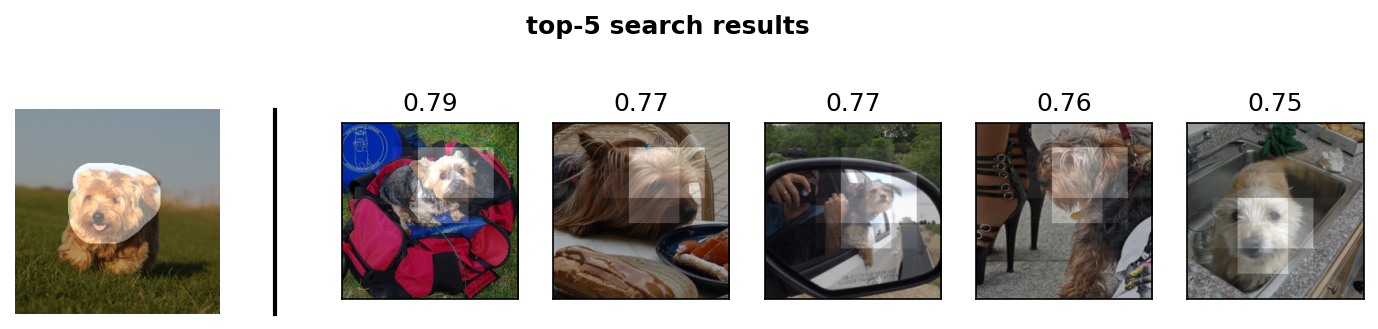

In [ ]:
selected_idx = int(highlight_index)
mask = vfs.util.durl_to_image(highlight_data)

cached_search_tool.set_input_image(model_query_imgs[selected_idx])

# turn the user's highlighted mask into a 7x7 grayscale array
conv5_transform = transforms.Resize(7)
conv5_mask = conv5_transform(mask)
conv5_mask_arr = np.asarray(conv5_mask)[:,:,3] / 255

print('Loading results...')
conv5_sims, conv5_xs, conv5_ys = cached_search_tool.compute(conv5_mask_arr)
conv5_order = torch.argsort(conv5_sims, descending=True)
print('Done.')

# ------------------------------------------------------------------------------
# set up the figure
DISPLAY_NUM = 5

fig = plt.figure(figsize=(11.6, 5.15), dpi=150)
fig.suptitle('top-5 search results', fontweight='bold', y=0.75)
gs = fig.add_gridspec(1,2, width_ratios=[1,5])
results_gs = gs[1].subgridspec(1,DISPLAY_NUM)

# show the query region on the left-hand side
ax = fig.add_subplot(gs[0])
ax.axis('off')
ax.imshow(vfs.util.mask_overlay(vis_query_imgs[selected_idx], 0, 0, 224, np.asarray(mask)[:,:,3] / 256))
ax.add_line(matplotlib.lines.Line2D([285,285], [0,224], lw=2, color='black')).set_clip_on(False)

# include the most similar images from the dataset on the right side
for i in range(DISPLAY_NUM):
  idx = conv5_order[i+0]
  curr_img_out = vfs.util.mask_overlay(get_coco_image(img_names[idx]),
                                   x=conv5_xs[idx],
                                   y=conv5_ys[idx],
                                   mask_size=7,
                                   mask=vfs.util.crop_mask(conv5_mask_arr))

  ax = fig.add_subplot(results_gs[i])
  ax.set_xticks([]);
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray')
  ax.set_title( f'{conv5_sims[idx].cpu().numpy():.02f}')